<a href="https://colab.research.google.com/github/shernee/04_cmpe258/blob/main/3layer_NN_numpy_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# initialize input parameters
n = 150
d = 3

# initialize random input data, weights and bias
x = np.random.uniform(-1, 1, (n, d))
weights_true = np.array([[3, -2, 4], ]).T
bias_true = np.array([[1.8]])

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}')

# non-linear equation
y_true = np.einsum('ij, jk -> ik', (x**3), weights_true) + np.einsum('ij, jk -> ik', (x**2), weights_true) - np.einsum('ij, jk -> ik', x, weights_true) + bias_true

print(f'y: {y_true.shape}')

x: (150, 3), weights: (3, 1), bias: (1,)
y: (150, 1)


In [ ]:
# class for the Linear layer

class Linear:
  def __init__(self, input_dim: int, hidden_dim:int = 1):
    self.weights = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
    self.bias = np.zeros(hidden_dim)

  # overload function operator, calculate function output with current weights and bias
  def __call__(self, x: np.ndarray):
    self.x = x
    y = np.einsum('ij, jk -> ik', (x**3), self.weights) + np.einsum('ij, jk -> ik', (x**2), self.weights) - np.einsum('ij, jk -> ik', x, self.weights) + self.bias
    return y

  # calculate local gradients using gradient of the layer in the front/output layer
  def backward(self, gradient: float):
    self.weights_gradient = np.einsum('ij, jk -> ik', self.x.T, gradient)
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = np.einsum('ij, jk -> ik', gradient, self.weights.T)
    return self.x_gradient

  # update the weights using the learning rate (lr) as a step and the weight and bias gradients calculated in the backward step
  def update(self, lr: float):
    self.weights = self.weights - (lr * self.weights_gradient)
    self.bias = self.bias - (lr * self.bias_gradient)

In [ ]:
# class for the non-linear/activation layer

class Relu:
  def __call__(self, input: np.ndarray):
    self.input = input
    self.output = np.clip(a=self.input, a_min=0, a_max=None) # clip values less than 0
    return self.output

  # calculate gradient for the relu layer using gradient from the layer in the front
  def backward(self, gradient: float):
    self.input_gradient = (self.input > 0) * gradient
    return self.input_gradient


In [ ]:
# class for the loss function (MSE)

class MSE:
  def __call__(self, y_true: np.ndarray, y_predicted: np.ndarray):
    self.y_true = y_true
    self.y_predicted = y_predicted
    return ((self.y_predicted - self.y_true) ** 2).mean() # loss=((y_pred - y_true)**2)/n

  # calculate loss gradient / gradient of the output layer
  def backward(self):
    self.n = self.y_true.shape[0]
    self.loss_gradient = 2.0 * (self.y_predicted - self.y_true) / n
    return self.loss_gradient


In [ ]:
# class for our entire non-linear model

class Model:
  # initialize our layers
  def __init__(self, input_dim: int, hidden_dim: int, output_dim: int = 1):
    self.linear1 = Linear(input_dim=input_dim, hidden_dim=hidden_dim)
    self.relu1 = Relu()
    self.linear2 = Linear(input_dim=hidden_dim, hidden_dim=hidden_dim)
    self.relu2 = Relu()
    self.linear3 = Linear(input_dim=hidden_dim, hidden_dim=output_dim)

  # call layers in a sequence
  def __call__(self, x:np.ndarray):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3

  # backward pass starting from the outer most layer to layer 1
  def backward(self, output_gradient: float):
    l3_gradient = self.linear3.backward(output_gradient)
    r2_gradient = self.relu2.backward(l3_gradient)
    l2_gradient = self.linear2.backward(r2_gradient)
    r1_gradient = self.relu2.backward(l2_gradient)
    l1_gradient = self.linear1.backward(r1_gradient)
    return l1_gradient

  def update(self, lr: float):
    self.linear3.update(lr=lr)
    self.linear2.update(lr=lr)
    self.linear1.update(lr=lr)

In [ ]:
# fit method for training of the model

def fit(x: np.ndarray, y_true:np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_predicted = model(x=x)
    loss_value = loss(y_true=y_true, y_predicted=y_predicted)
    print(f'Epoch: {epoch}; Loss Value: {loss_value}')
    loss_gradient = loss.backward()
    model.backward(output_gradient=loss_gradient)
    model.update(lr=lr)

In [ ]:
# initialize model parameters
input_dim = d
hidden_dim = 10
output_dim = 1
lr = 0.1
num_epochs = 40

model = Model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
loss = MSE()

fit(x=x, y_true=y_true, model=model, loss=loss, lr=lr, num_epochs=num_epochs)

Epoch: 0; Loss Value: 6.110274249093739
Epoch: 1; Loss Value: 4.8231553539332905
Epoch: 2; Loss Value: 36.32543494726824
Epoch: 3; Loss Value: 3.912604364731678
Epoch: 4; Loss Value: 6.468603604648995
Epoch: 5; Loss Value: 10.326192332707626
Epoch: 6; Loss Value: 9.08829821577303
Epoch: 7; Loss Value: 8.023703385306053
Epoch: 8; Loss Value: 11.306742170424457
Epoch: 9; Loss Value: 2.938662819294939
Epoch: 10; Loss Value: 4.5468086365023614
Epoch: 11; Loss Value: 3.3547679248607922
Epoch: 12; Loss Value: 3.6907401675327645
Epoch: 13; Loss Value: 2.938805485203792
Epoch: 14; Loss Value: 3.742358560631496
Epoch: 15; Loss Value: 3.205328378466653
Epoch: 16; Loss Value: 6.894147175995598
Epoch: 17; Loss Value: 11.454398664630443
Epoch: 18; Loss Value: 78.33503993480063
Epoch: 19; Loss Value: 24.401544609342615
Epoch: 20; Loss Value: 4.475203496012931
Epoch: 21; Loss Value: 3.3770675531740486
Epoch: 22; Loss Value: 2.5808633327855386
Epoch: 23; Loss Value: 2.248735841936263
Epoch: 24; Loss V

In [ ]:
# Initialise model and loss
model = Model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
loss = MSE()

# Train model - one forward and one backward pass for visualization
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(lr)
y_pred = model(x)

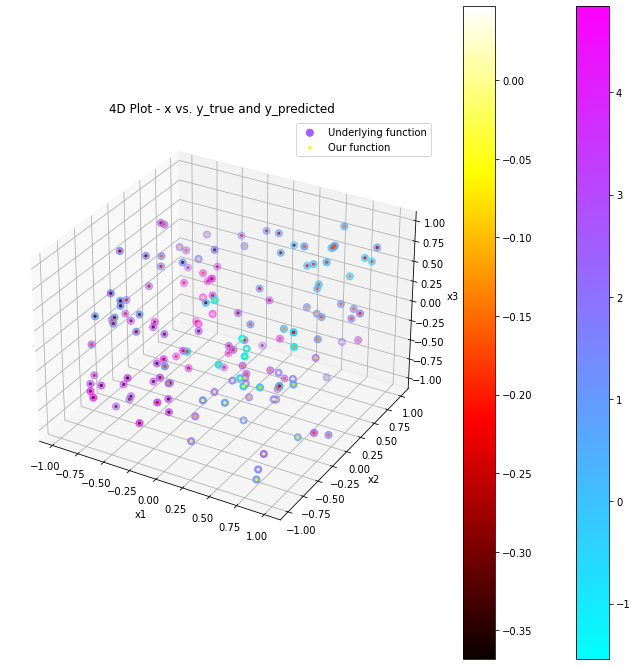

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
scatter_fig = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_true, cmap='cool', label='Underlying function', s=50)
fig.colorbar(scatter_fig)
scatter_fig = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_pred, cmap='hot', label='Our function', marker='.')
fig.colorbar(scatter_fig)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('4D Plot - x vs. y_true and y_predicted')

plt.legend()
plt.show()